## Решение ML-задачи по оттоку клиентов

Используемая метрика - roc-auc, применяются обычные модели и catboost.

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
data = pd.read_csv('./train.csv')

In [ ]:
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [ ]:
data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

In [ ]:
data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [ ]:
data.sample()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
3491,60,100.5,6029,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),0


## Анализ данных

Несколько диаграмм и графиков для того, чтобы посмотреть, как распределены разные значения. Также в начале сделано преобразование данных, т.к. разными проверками было выявлено наличие пустых значений в одной из колонок.

In [ ]:
data['TotalSpent'] = data['TotalSpent'].replace(' ', 0)
data['TotalSpent'] = data['TotalSpent'].astype(float)

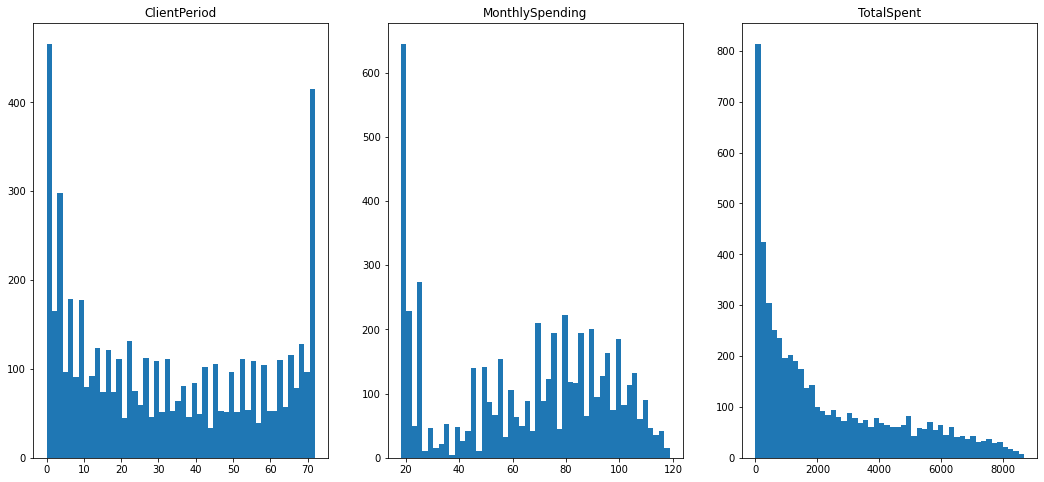

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18,8))

ax = ax.ravel()

for i in range(3):
    ax[i].set_title(num_cols[i])
    ax[i].hist(data[num_cols[i]], bins=50)
    
fig.show()

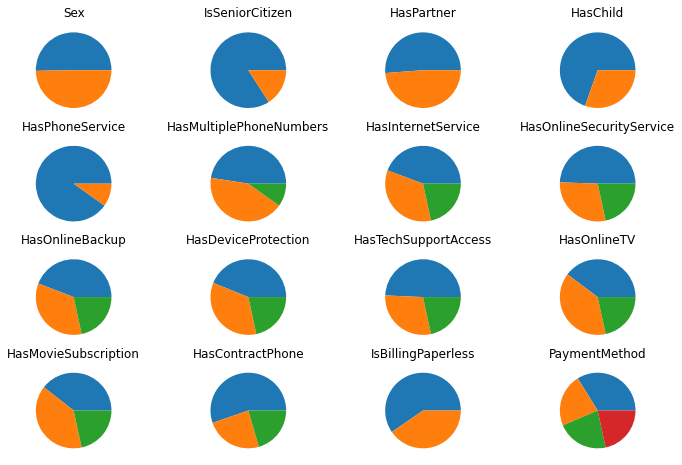

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(12,8))

ax = ax.ravel()

for i in range(16):
    ax[i].set_title(cat_cols[i])
    ax[i].pie(data[cat_cols[i]].value_counts())
    
fig.show()

## Применение линейных моделей (3 балла)

Здесь я пробую применять линейные модели и делаю нормировку признаков + one-hot-encoding и кросс-валидацию.

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

In [ ]:
le=LabelEncoder()
enc=OneHotEncoder()
for col in cat_cols:
  data[col]=le.fit_transform(data[col])
  data[col]=data[col].astype('category')

In [ ]:
def ohe(df, numeric, categorical):
    dummy_features = pd.get_dummies(df[categorical])
    return pd.concat([df[numeric], dummy_features], axis=1)


In [ ]:
def allscores(ytrue, ypred):
    print('rocauc:', roc_auc_score(ytrue, ypred))

In [ ]:
def write_to_submission_file(predicted_labels, out_file, target='Churn', index_label="Id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(len(predicted_labels)),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [ ]:
X = data[feature_cols]
y = data['Churn']

In [ ]:
X = ohe(X, num_cols, cat_cols)
test_ohe = ohe(test_df, num_cols, cat_cols)

In [ ]:
sc = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
model = LogisticRegression()

model.fit(X_train, y_train)
test_pred = model.predict(X_test)
allscores(y_test, test_pred)

rocauc: 0.7158659631583819


In [ ]:
params = {"C":[0.001, 0.01, 0.1, 1, 10, 100, 1000], 
          "penalty":["l1","l2", "elasticnet"],
          "solver":["lbfgs", "saga"],
          "random_state":[42],
          "class_weight":[{0:1,1:3}, {0:1,1:2}]
         }
model = LogisticRegression()
model_cv = GridSearchCV(model, param_grid=params,cv=7)
model_cv.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection

GridSearchCV(cv=7, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': [{0: 1, 1: 3}, {0: 1, 1: 2}],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'random_state': [42], 'solver': ['lbfgs', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=Fal

In [ ]:
print("best parameters: ", model_cv.best_params_)
print("best_score: ", model_cv.best_score_)

best parameters:  {'C': 0.01, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga'}
best_score:  0.7756161638982634


In [ ]:
test_pred = model_cv.predict(X_test)
allscores(y_test, test_pred)

rocauc: 0.7630519300194392


## Применение градиентного бустинга

Буду использовать catboost, не надо кодировать категориальные признаки.

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

     |████████████████████████████████| 66.3MB 61kB/s 


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[feature_cols], data[["Churn"]], test_size=0.2, random_state=42)

In [ ]:
test_model_grid = CatBoostClassifier(silent=True,
                                             cat_features=cat_cols,
                                             eval_metric='AUC', l2_leaf_reg=0.15789473684210523)
test_model_grid.grid_search({'learning_rate': np.linspace(0, 1, 20), 'n_estimators': np.linspace(0, 1000, 40)}, 
                           X_train, 
                           y_train, plot=True, refit=True)


In [ ]:
model_CB_default = CatBoostClassifier(random_seed=42, )
model_CB_default.fit(X_train, 
                     y_train,
                     cat_features=cat_cols,
                     silent=True)
predict = model_CB_default.predict_proba(X_test)[:,-1]

In [ ]:
params = { 'iterations':[100]
          ,'l2_leaf_reg':[1,3,5,10]
          ,'learning_rate':[0.001,0.01]
          ,'depth':[3,5,7,10]
          ,'loss_function':['CrossEntropy']
}

In [ ]:
roc_auc_score(y_test, predict)

0.821409111478468

Вот одно из лучших качеств, что я получил


# Предсказания

In [ ]:
best_model = model_CB_default

In [ ]:
X_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv')

submission['Churn'] = best_model.predict_proba(X_test)[:, 1]
submission.to_csv('./my_submission.csv', index=False)